In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
all_cols = ['time', 'user_screen_name', 'user_id', 'user_verified',
       'user_followers_count', 'user_friends_count', 'user_favourites_count',
       'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism',
       'pessimism', 'sadness', 'surprise', 'trust', 'care', 'harm', 'fairness',
       'cheating', 'loyalty', 'betrayal', 'authority', 'subversion', 'purity',
       'degradation', 'count']
user_attr_cols = ['user_screen_name', 'user_id', 'user_verified',
       'user_followers_count', 'user_friends_count', 'user_favourites_count']
emot_mf_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism',
       'pessimism', 'sadness', 'surprise', 'trust', 'care', 'harm', 'fairness',
       'cheating', 'loyalty', 'betrayal', 'authority', 'subversion', 'purity',
       'degradation', 'count']

In [2]:
# per user per hour aggregation


df = pd.read_csv('/nas/home/siyiguo/user_similarity/data/LA_tweets_emot_mf_user_hourly_ts.csv')
df['time'] = pd.to_datetime(df['time'])
print(df.shape)

(12088001, 29)


In [13]:
# get overall user activity stats within the entire data
user_all_activity = df.groupby('user_screen_name')['count'].sum()

# user_all_activity.plot(kind='hist',bins=10000) not useful

# show quantiles
user_all_activity.quantile(q=[0.25,0.5,0.75,1.0])

# so we can take users with more than 20 tweets

0.25         1.0
0.50         4.0
0.75        18.0
1.00    199272.0
Name: count, dtype: float64

In [17]:
active_users = list(user_all_activity.index[user_all_activity>=20])
print(len(active_users))

96787


In [20]:
active_user_df = df[df.user_screen_name.isin(set(active_users))]
active_user_df.to_csv('/nas/home/siyiguo/user_similarity/data/LA_tweets_emot_mf_active_user_hourly_ts.csv',index=False)

In [5]:
active_user_df = pd.read_csv('/nas/home/siyiguo/user_similarity/data/LA_tweets_emot_mf_active_user_hourly_ts.csv')
active_user_df['time'] = pd.to_datetime(active_user_df['time'])
print(len(active_user_df))

11001563


num data points (8785, 28)


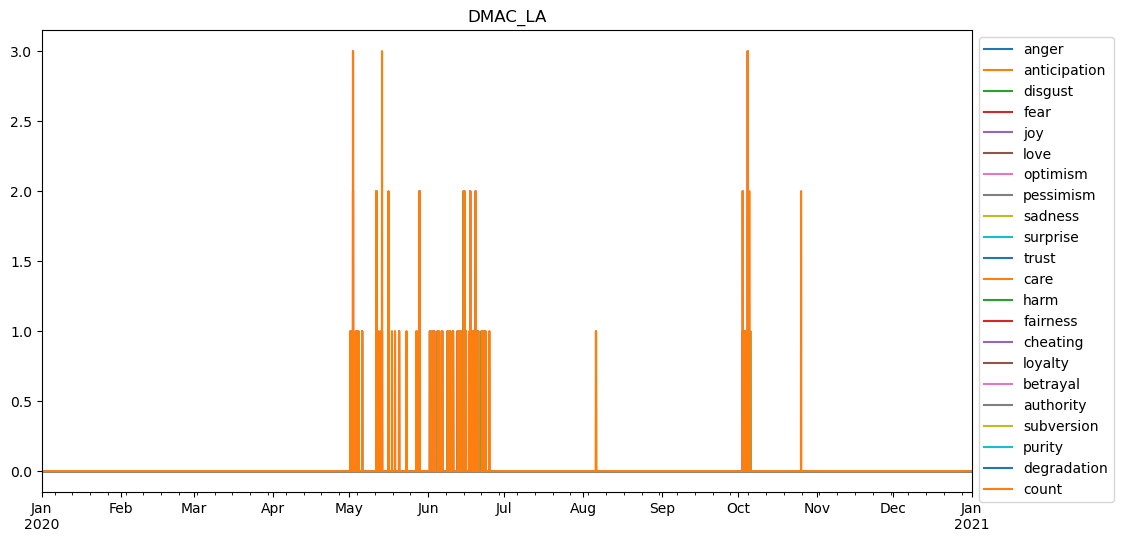

num data points (8785, 28)


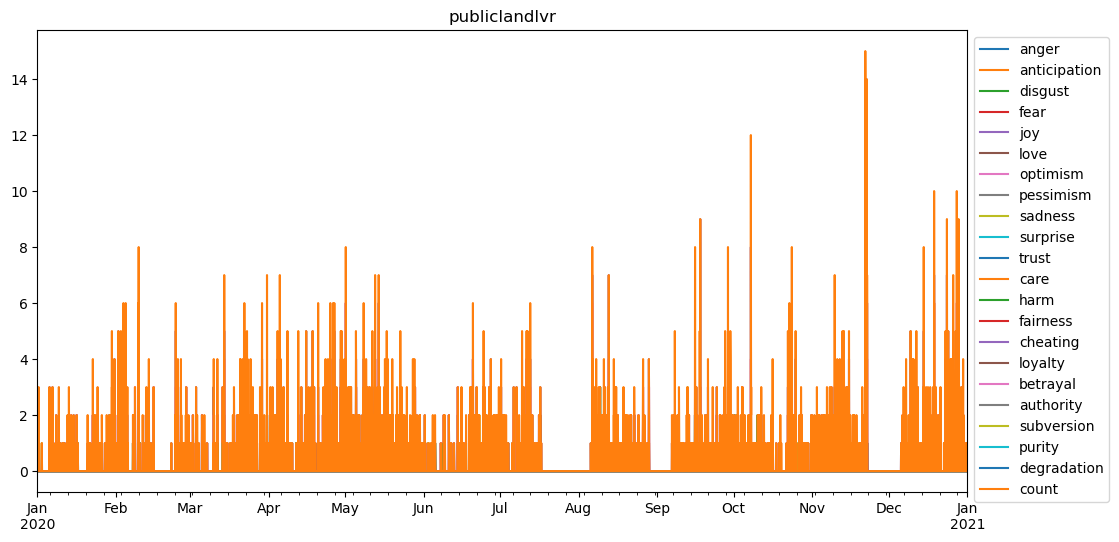

num data points (8785, 28)


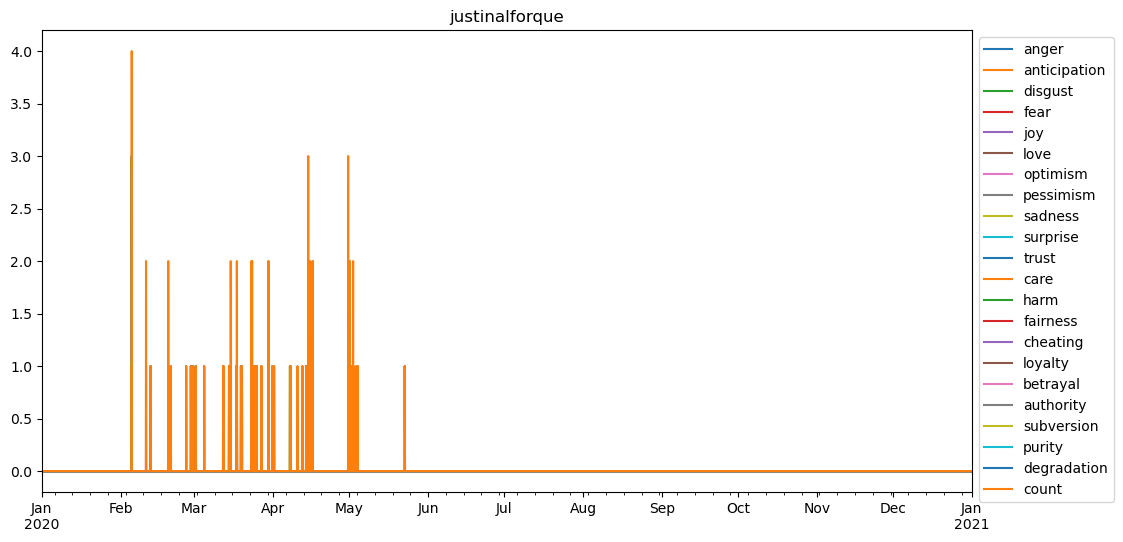

num data points (8785, 28)


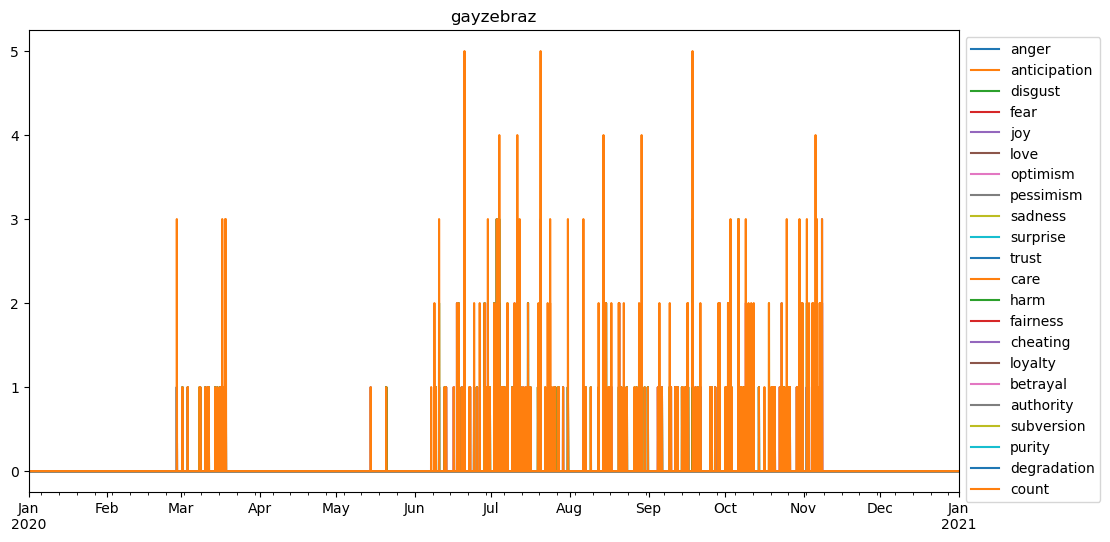

num data points (8785, 28)


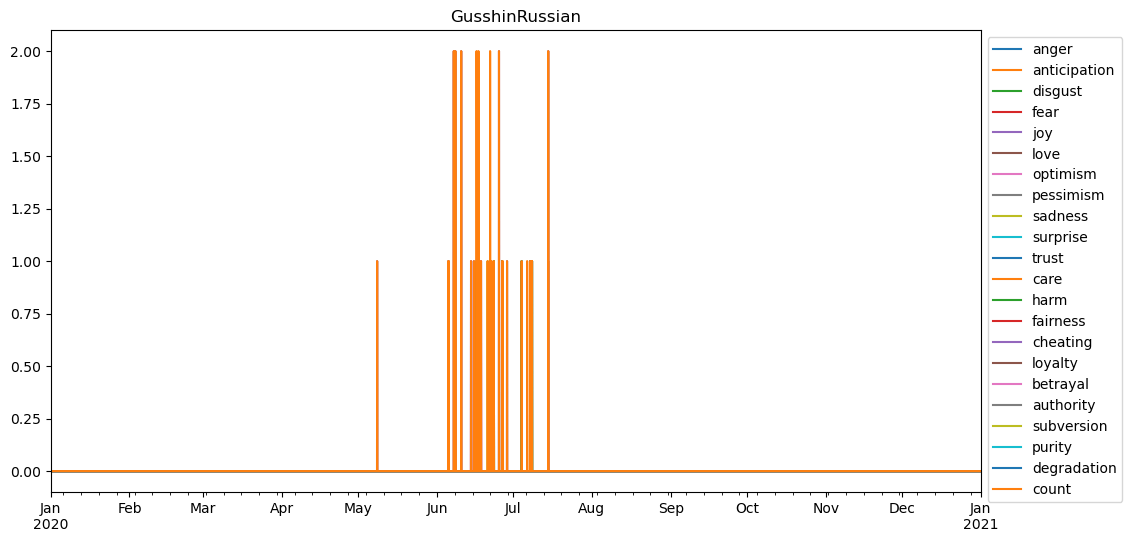

num data points (8785, 28)


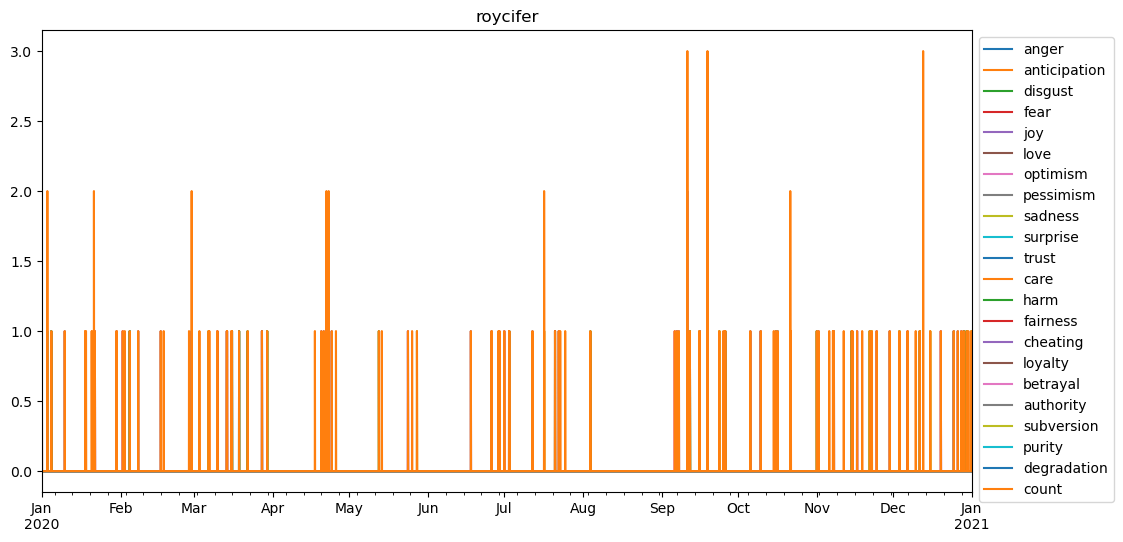

num data points (8785, 28)


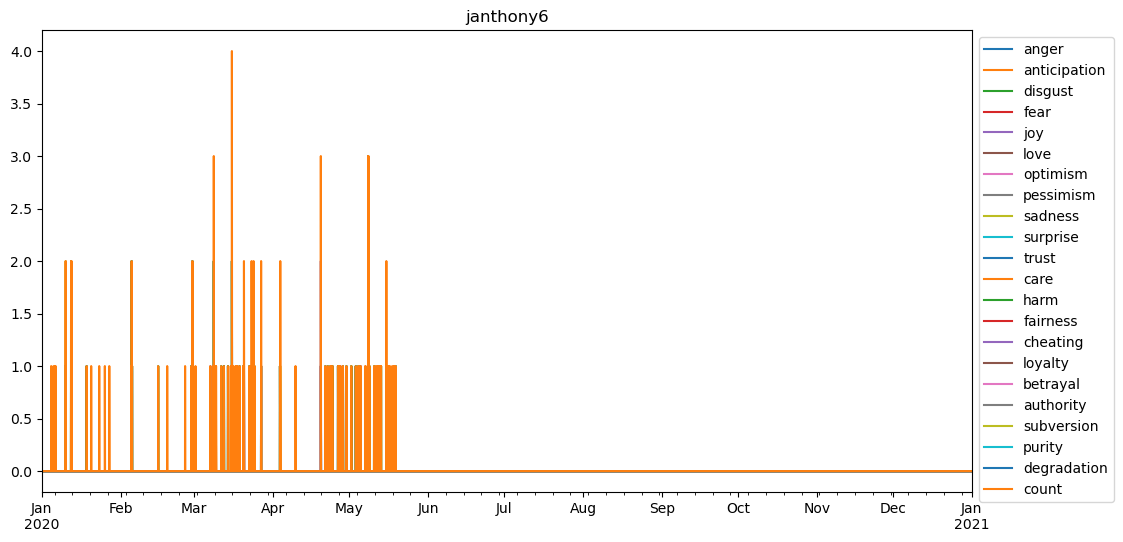

num data points (8785, 28)


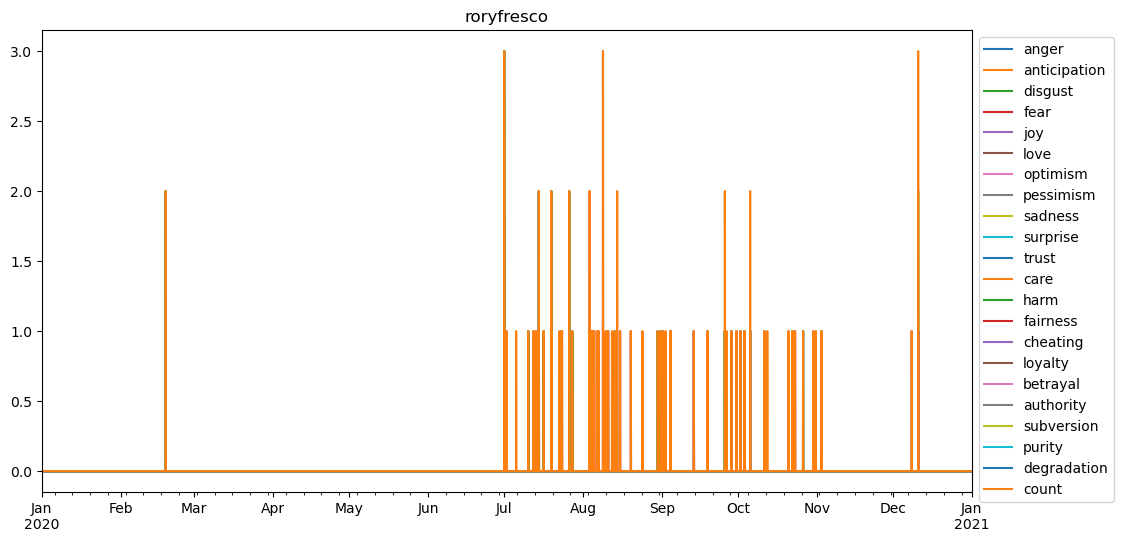

num data points (8785, 28)


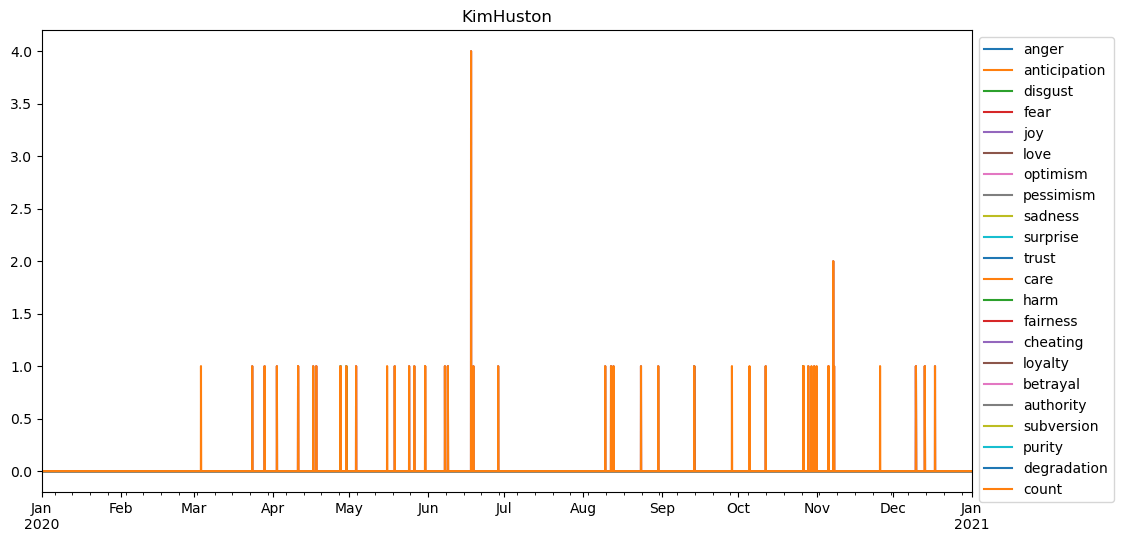

num data points (8785, 28)


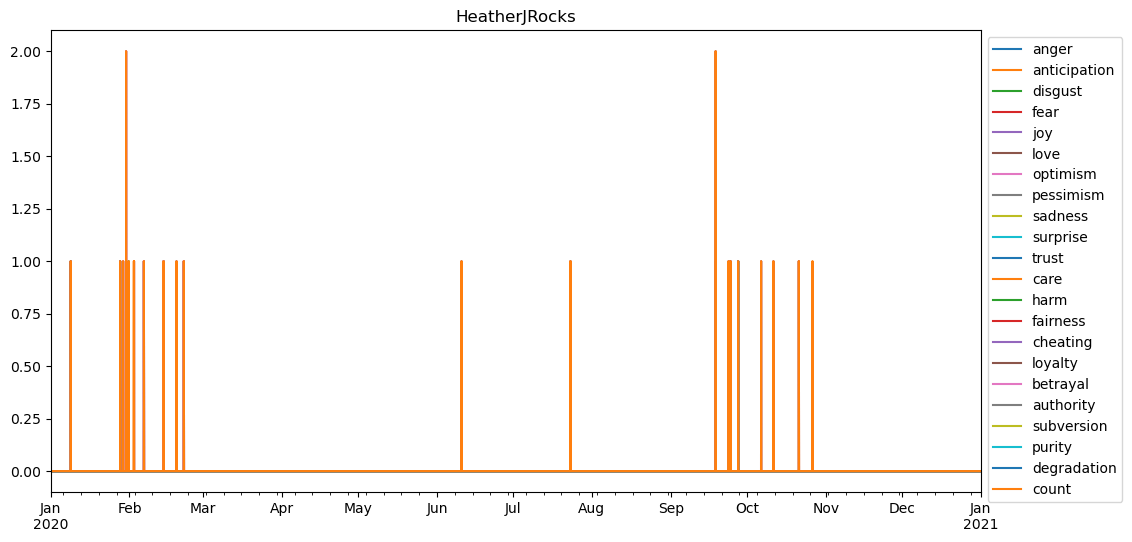

In [35]:
# look at how time series for different users look like
random.seed(10)

full_daterange = pd.date_range(start='2020-01-01',end='2021-01-01',freq='H',tz='US/Pacific')

for user in random.sample(list(pd.unique(active_user_df.user_screen_name)),10):
    tmp = active_user_df[active_user_df.user_screen_name==user].set_index('time').reindex(full_daterange)
    print('num data points', tmp.shape)
    tmp[emot_mf_cols].fillna(0).plot(figsize=[6,2])
    plt.title(user)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

num data points (8785, 28)


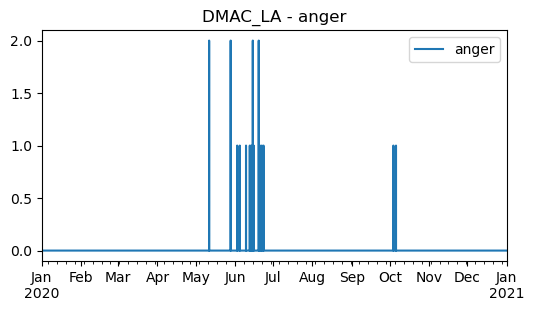

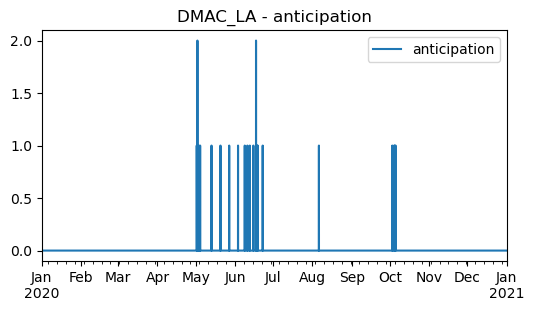

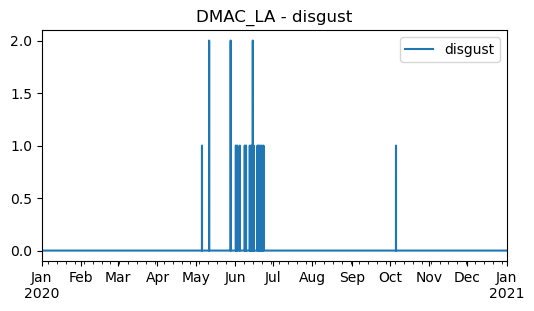

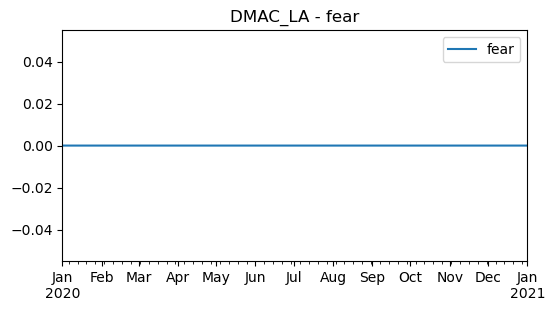

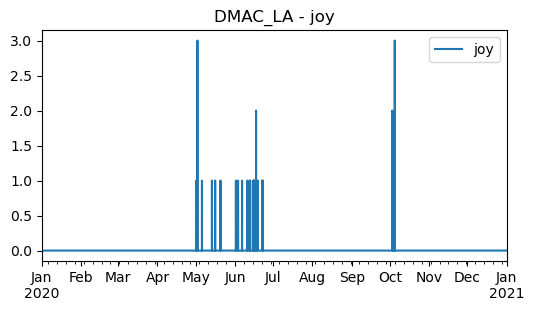

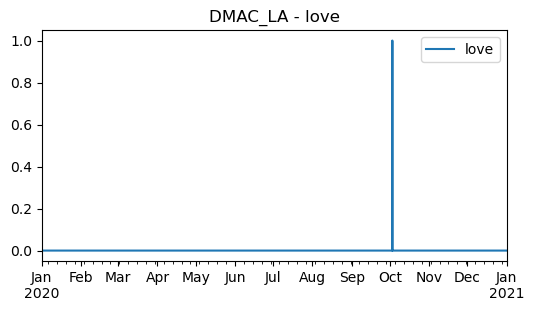

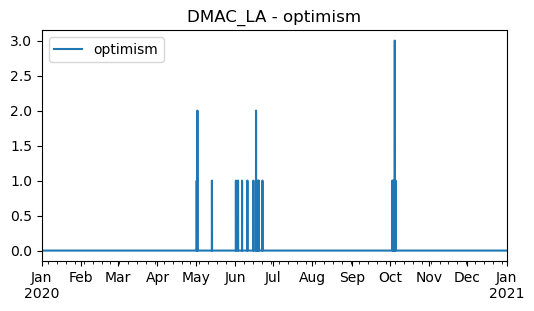

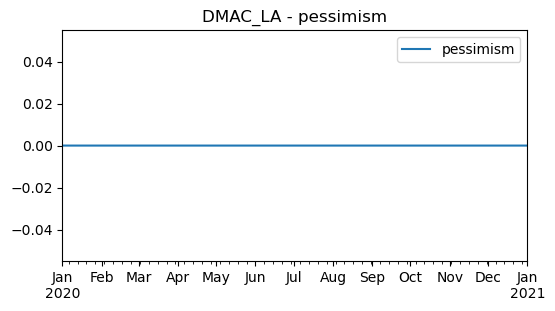

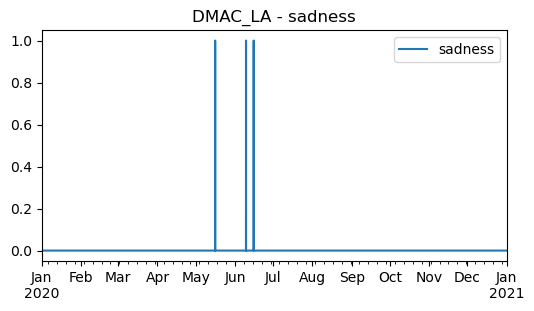

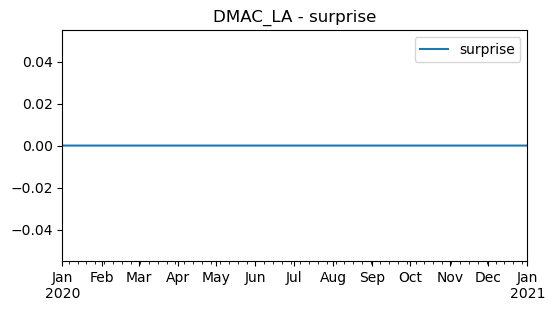

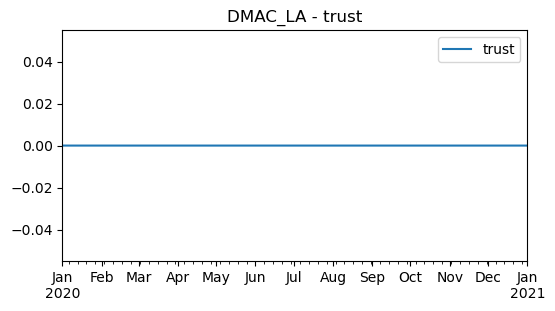

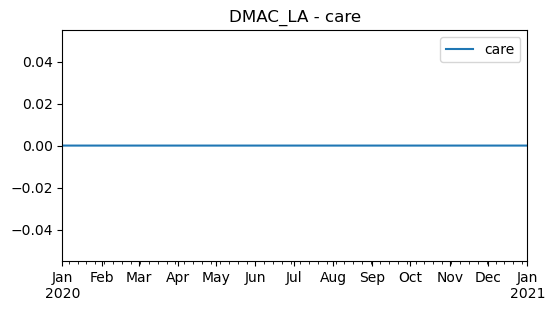

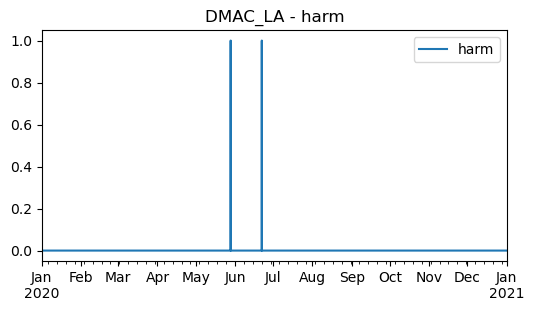

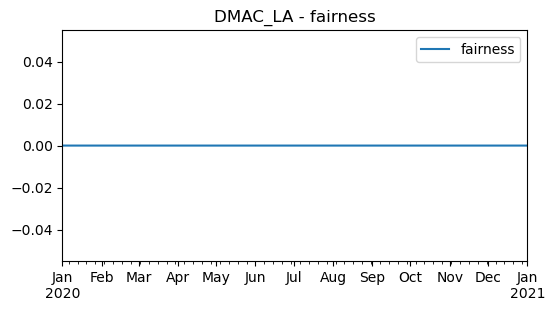

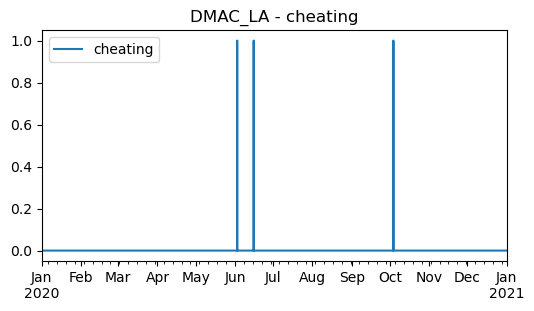

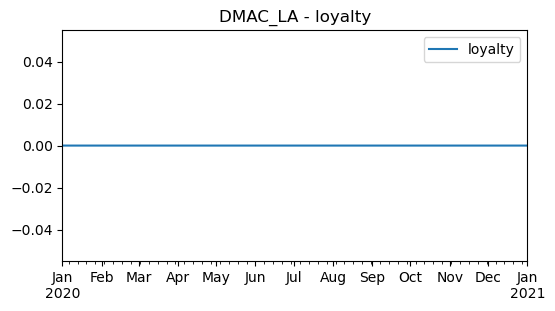

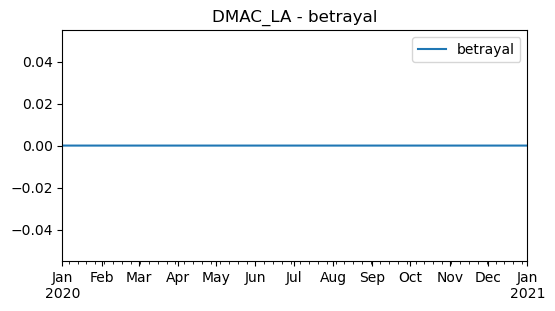

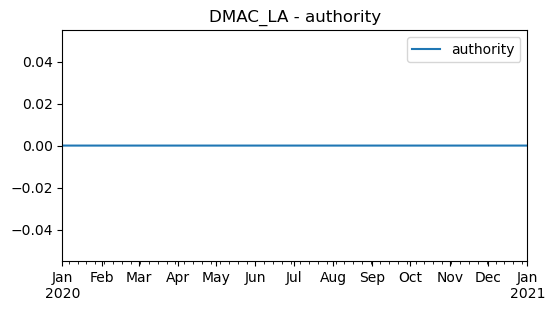

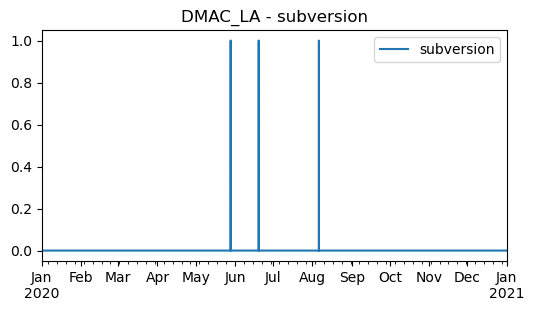

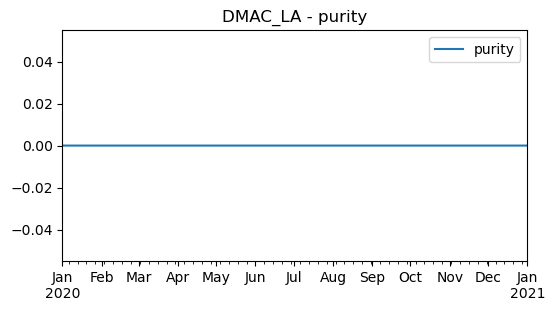

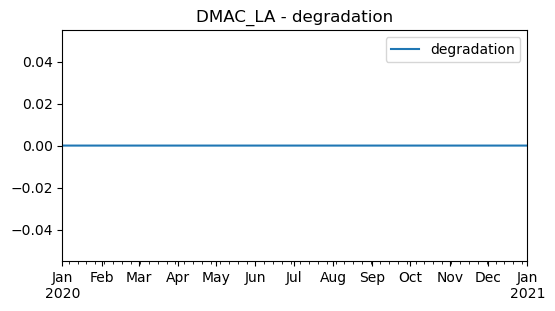

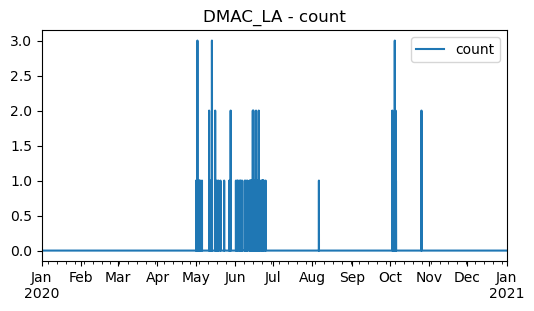

num data points (8785, 28)


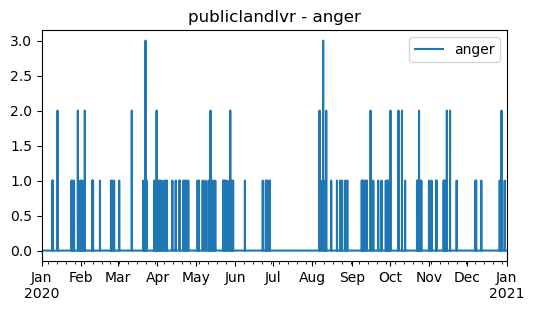

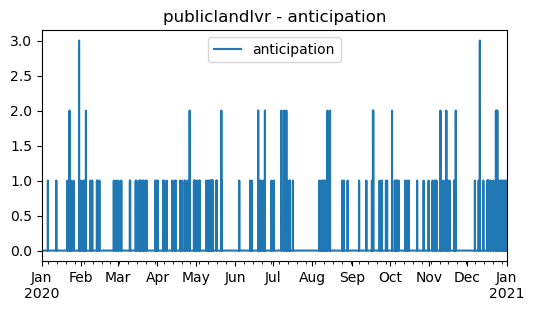

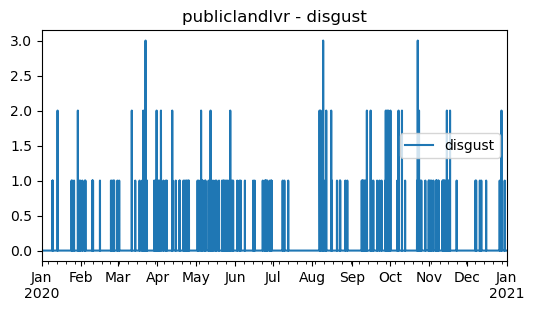

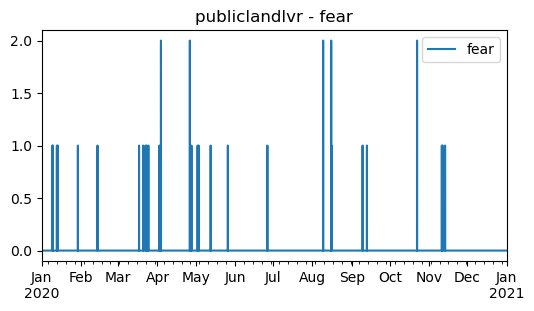

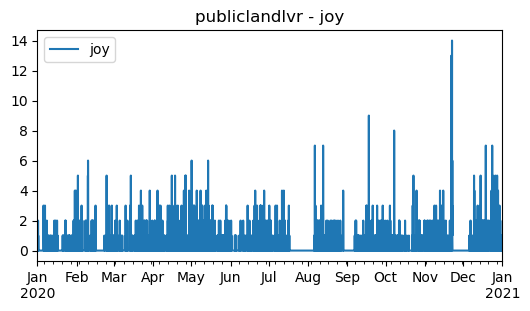

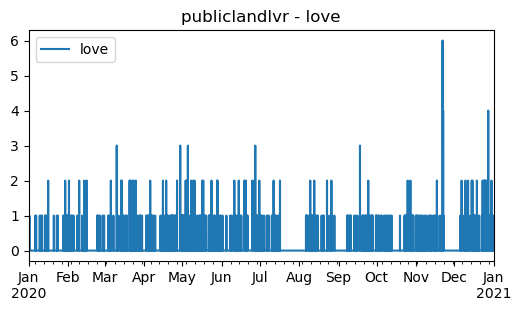

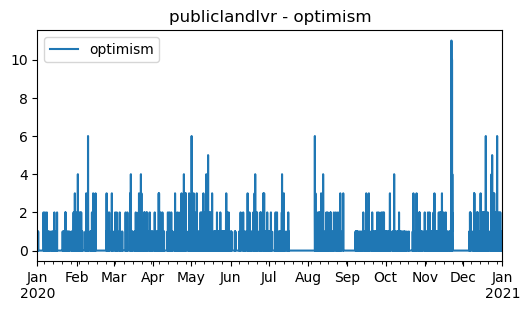

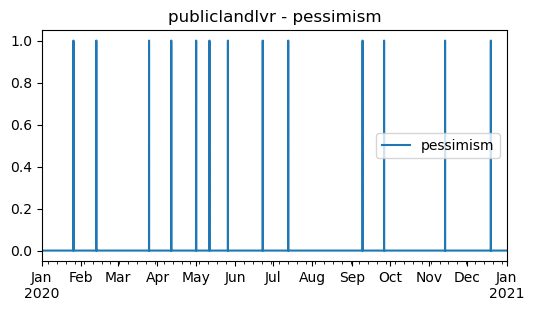

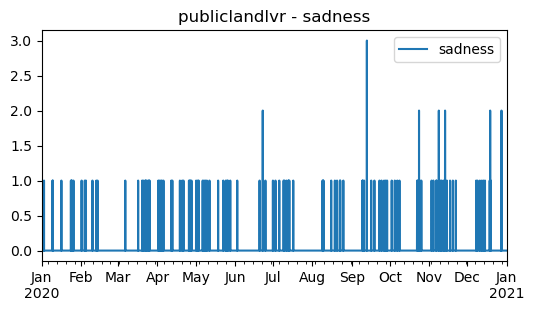

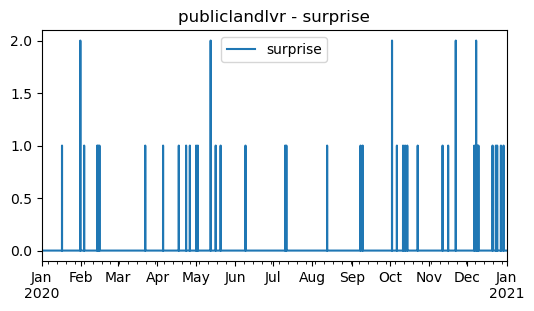

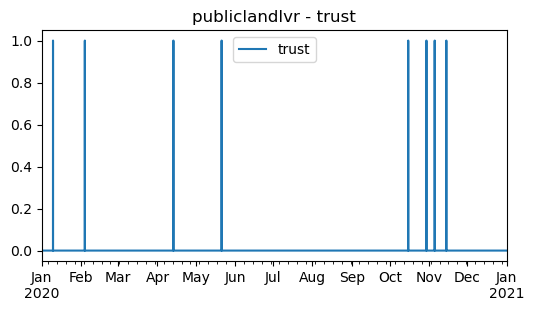

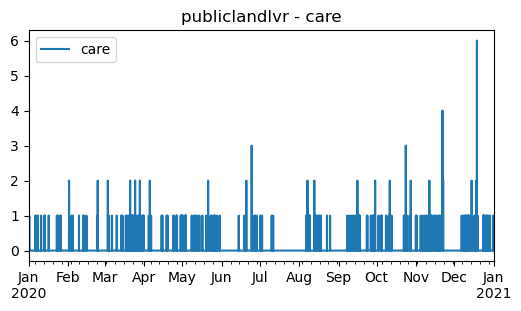

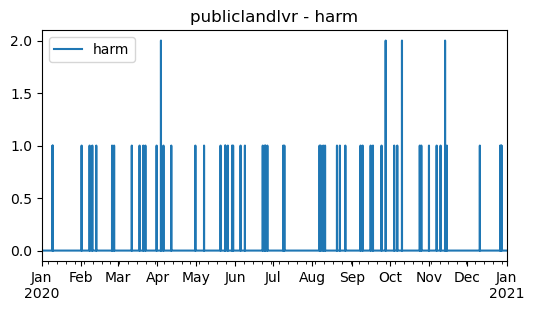

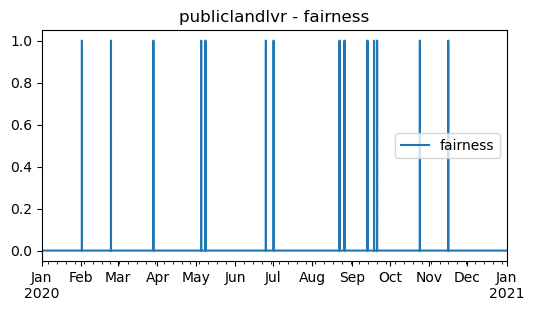

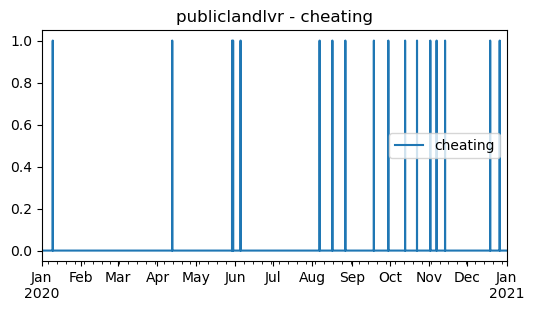

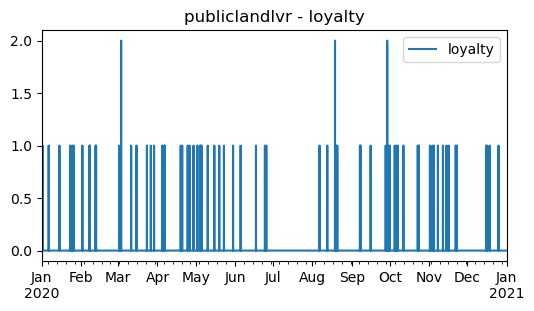

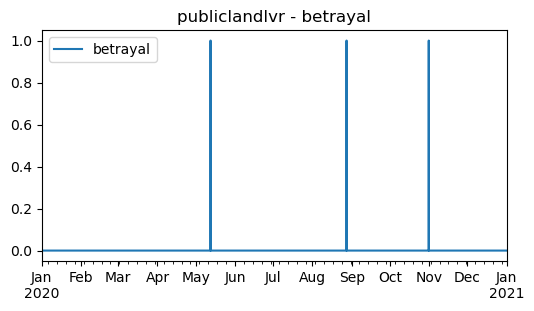

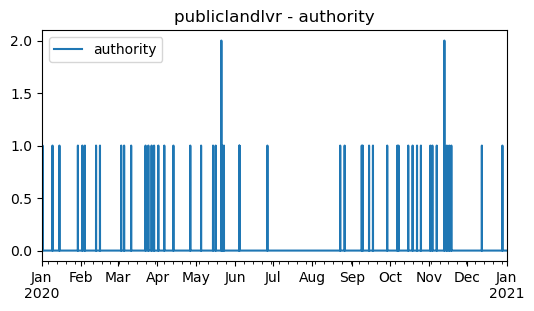

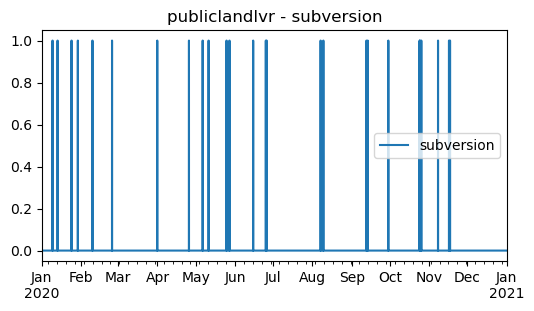

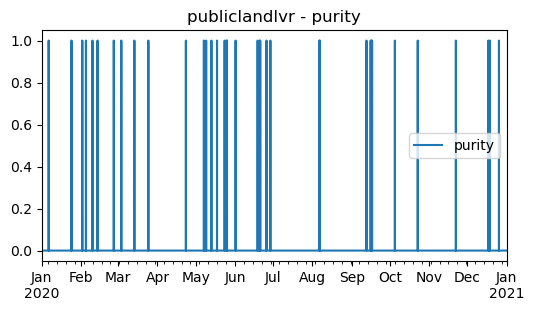

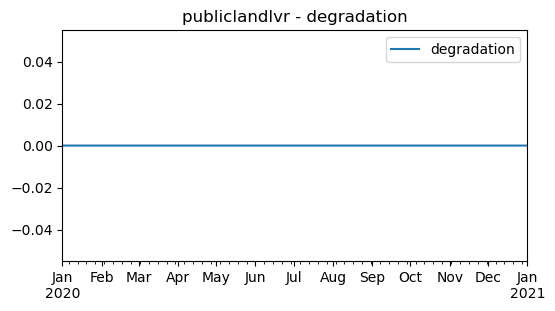

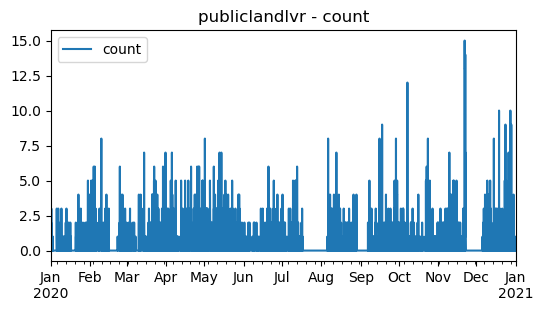

num data points (8785, 28)


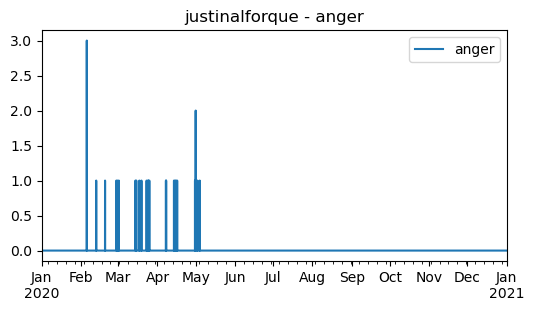

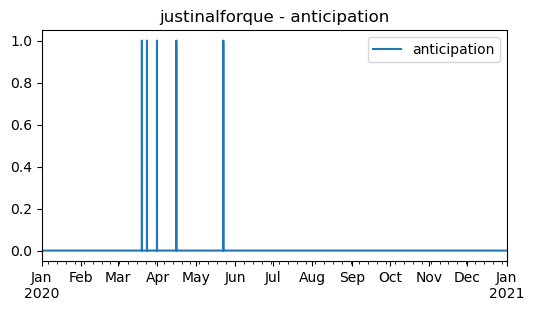

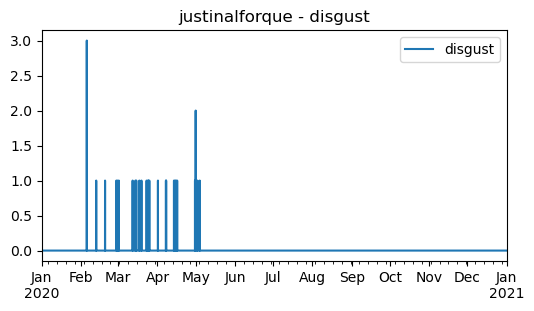

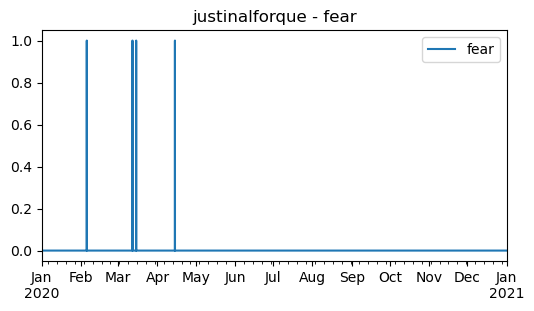

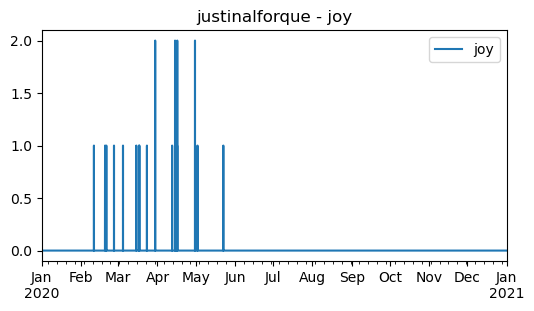

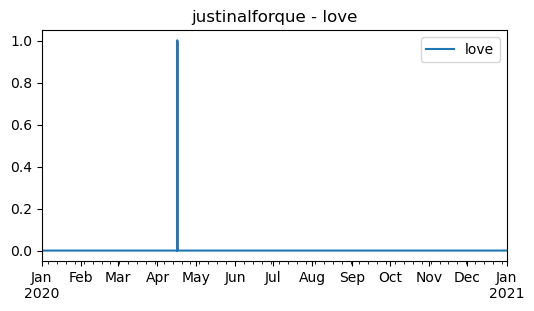

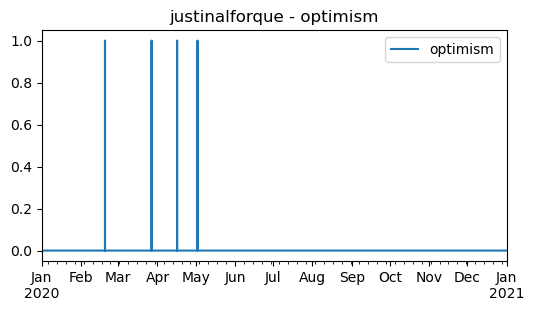

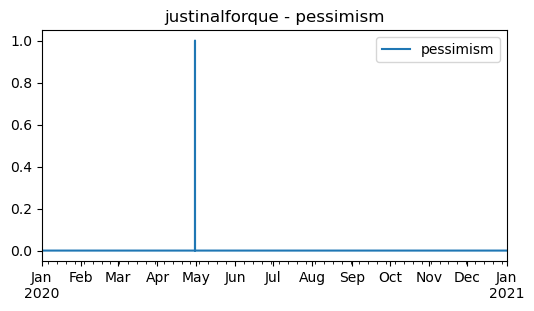

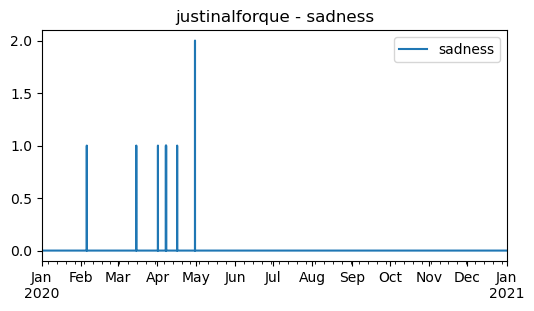

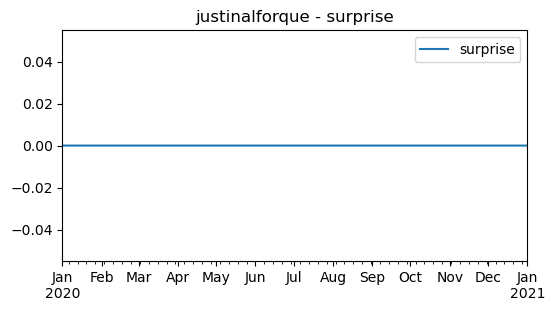

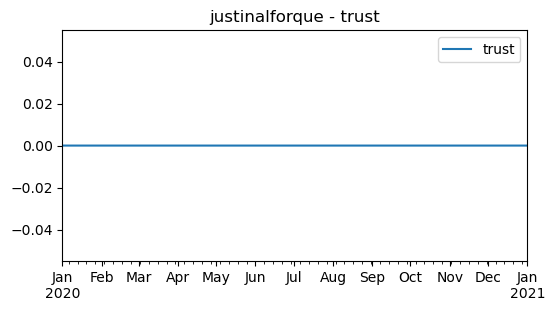

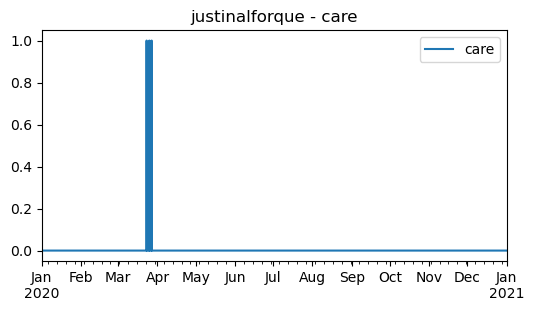

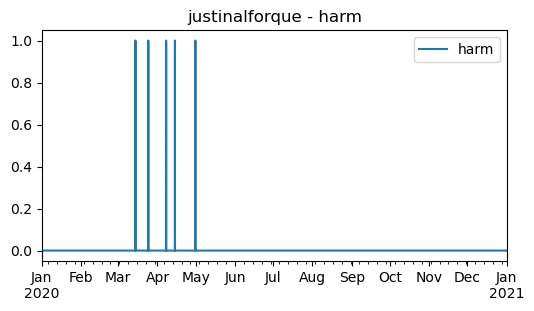

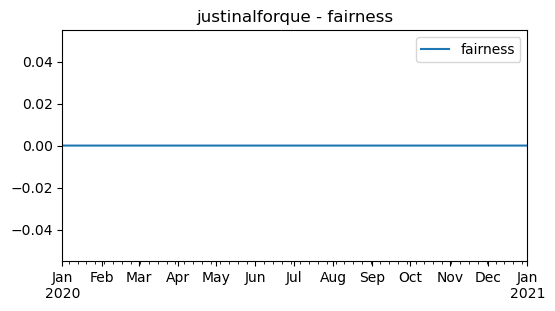

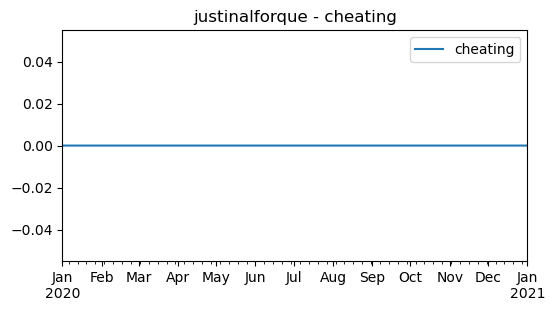

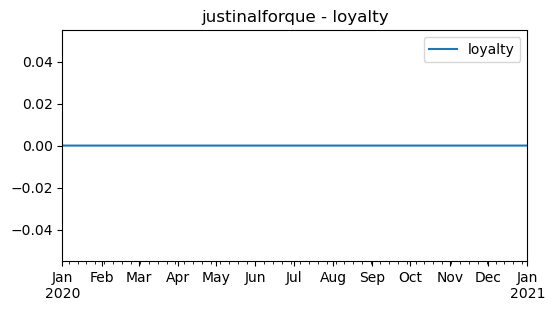

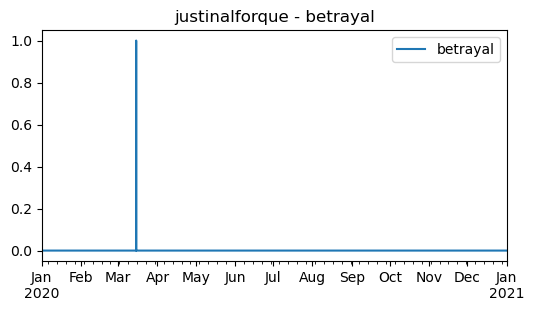

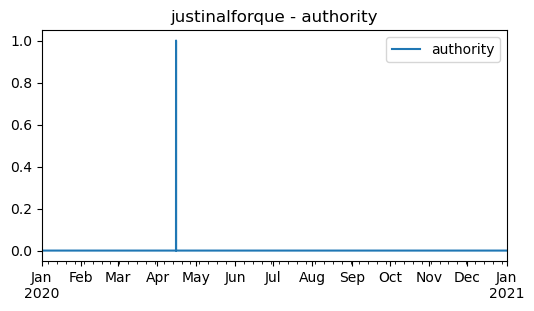

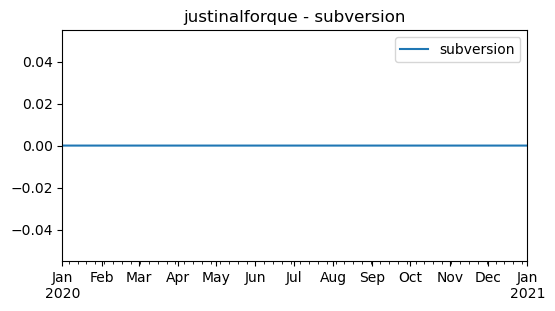

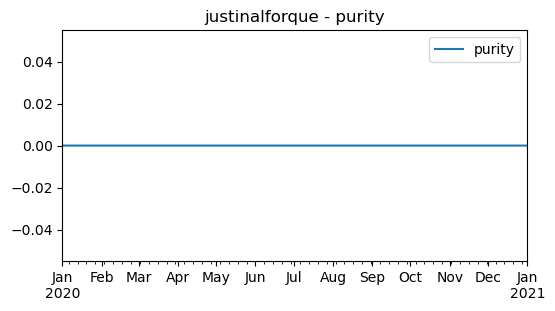

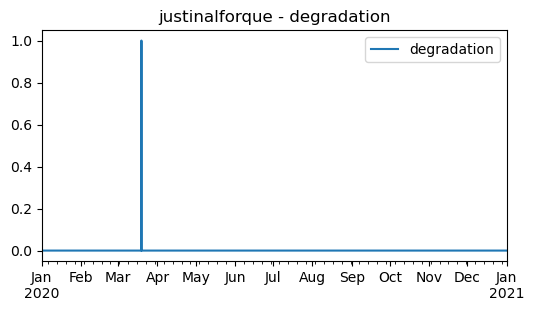

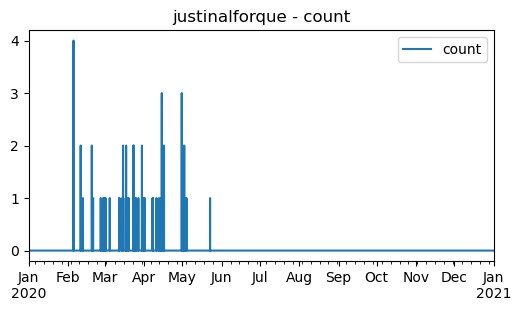

In [38]:
# look at ts of individual emotion/mf variable for each user

random.seed(10)

full_daterange = pd.date_range(start='2020-01-01',end='2021-01-01',freq='H',tz='US/Pacific')

for user in random.sample(list(pd.unique(active_user_df.user_screen_name)),3):
    tmp = active_user_df[active_user_df.user_screen_name==user].set_index('time').reindex(full_daterange)
    print('num data points', tmp.shape)
    for c in emot_mf_cols:
        tmp[c].fillna(0).plot(figsize=[6,3])
        plt.title(user+' - '+c)
        plt.legend() #bbox_to_anchor=(1,1))
        plt.show()

len of data=88, sum=2


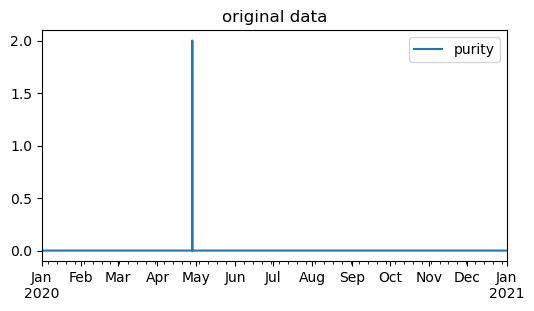


bootstrapping:
len of data=52, sum=6


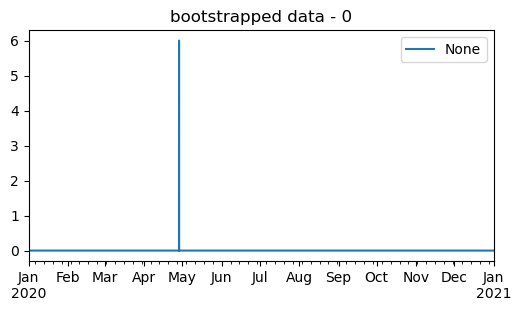

len of data=53, sum=2


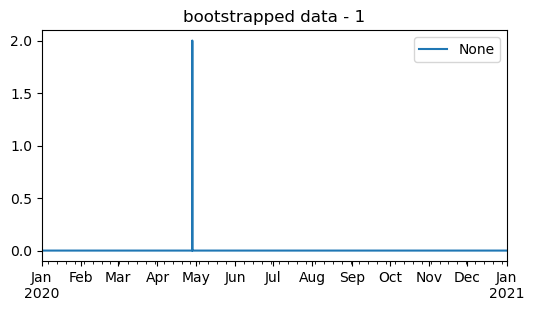

len of data=56, sum=4


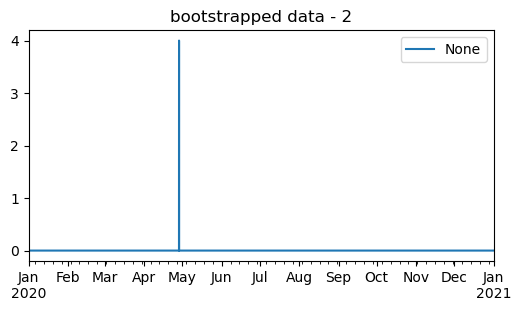

len of data=54, sum=0


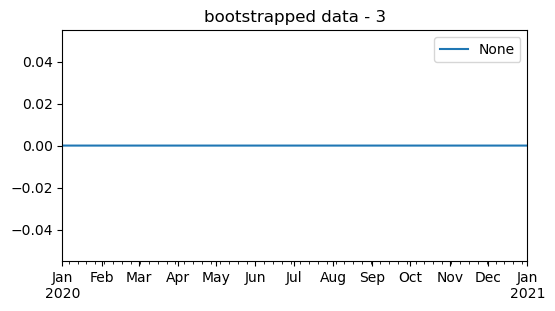

len of data=59, sum=0


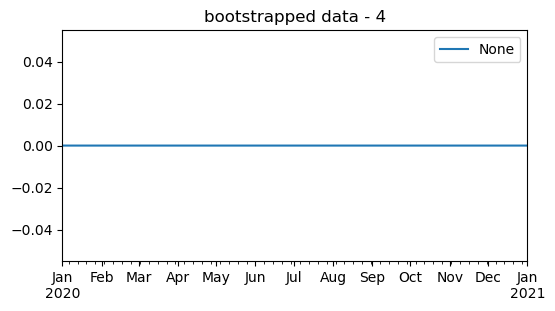

In [7]:
# try bootstrapping to generate positive examples
full_daterange = pd.date_range(start='2020-01-01',end='2021-01-01',freq='H',tz='US/Pacific')
# tmp = active_user_df[active_user_df.user_screen_name=='DMAC_LA'].set_index('time').reindex(full_daterange)['anger'].fillna(0)
tmp = active_user_df[active_user_df.user_screen_name=='BrandonBennick'].set_index('time')['purity']
print(f'len of data={len(tmp)}, sum={tmp.sum()}')
tmp.reindex(full_daterange).fillna(0).plot(figsize=[6,3])
plt.legend()
plt.title('original data')
plt.show()

print('\nbootstrapping:')
for i in range(5):
    random.seed(i)
    btstrpd = random.choices(list(tmp.items()),k=len(tmp))
    btstrpd = pd.Series([i[1] for i in btstrpd],index=[i[0] for i in btstrpd])
    btstrpd = btstrpd.groupby(level=0).sum()
    print(f'len of data={len(btstrpd)}, sum={btstrpd.sum()}')

    btstrpd.reindex(full_daterange).fillna(0).plot(figsize=[6,3])
    plt.legend()
    plt.title(f'bootstrapped data - {i}')
    plt.show()

In [24]:
def generate_positive_example(ts, cols, seed=3, debug=False):
    """
    generate one positive example using bootstrapping

    ts: pd.DataFrame, index is time, column is user attributes + number of tweets with emot/mf per hour
    cols: the column names needs to be augmented
    seed: random seed
    debug: bool, whether to print and plot
    return - results: list of tuples (time, variable, value)
    """
    result = []

    for c in cols:
        tmp = ts[c]
        tmp = tmp[tmp != 0]

        # what the original looks like
        if debug:
            print(f'{ts.user_screen_name.iloc[0]} - {c}')
            print(f'original data: len of data={len(tmp)}, sum={tmp.sum()}')
            # plot
            tmp.reindex(full_daterange).fillna(0).plot(figsize=[6,3])
            plt.legend()
            plt.title(f'original data - {ts.user_screen_name.iloc[0]} - {c}')
            plt.show()

        if len(tmp) <= 5:
            random.seed(seed)
            # randomly add 1 to 5 signals
            random_time_points = random.choices(list(ts.index),k=random.choice(list(range(0,6,1))))
            if debug:
                print(f'create positive sample with {len(random_time_points)} points')
            result.extend([(i,c,1) for i in random_time_points])
        else:
            # bootstrapping
            random.seed(seed)
            btstrp_range = list(range(int(len(tmp)*0.7), int(len(tmp)*1.3)+2, 1)) # a range of the number of data points as the output of bootstrapping, e.g. original data have 50 data points, we can bootstrap 45 data points, or 55.
            print(btstrp_range, random.choice(btstrp_range))
            btstrpd = random.choices(list(tmp.items()),k=random.choice(btstrp_range)) 
            print(btstrpd)
            btstrpd = pd.Series([i[1] for i in btstrpd],index=[i[0] for i in btstrpd])
            print(btstrpd)
            btstrpd = btstrpd.groupby(level=0).sum()
            print(btstrpd)
            if debug:
                print(f'bootstrapped data: len of data={len(btstrpd)}, sum={btstrpd.sum()}')
                # plot
                btstrpd.reindex(full_daterange).fillna(0).plot(figsize=[6,3])
                plt.legend()
                plt.title(f'bootstrapped data - {ts.user_screen_name.iloc[0]} - {c}')
                plt.show()
            
            result.extend([(i[0],c,i[1]) for i in list(btstrpd.items())])
    
    return result

BrandonBennick - purity
original data: len of data=1, sum=2


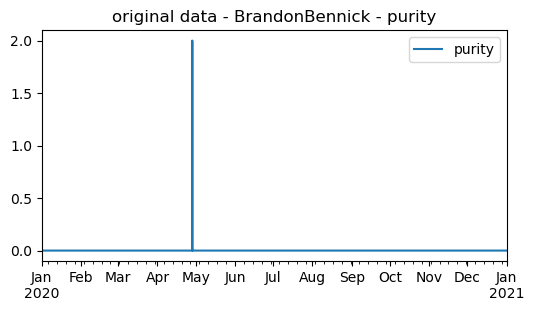

create positive sample with 4 points


[(datetime.datetime(2020, 5, 1, 8, 0, tzinfo=tzoffset(None, -25200)),
  'purity',
  1),
 (datetime.datetime(2020, 5, 7, 10, 0, tzinfo=tzoffset(None, -25200)),
  'purity',
  1),
 (datetime.datetime(2020, 5, 23, 18, 0, tzinfo=tzoffset(None, -25200)),
  'purity',
  1),
 (datetime.datetime(2020, 6, 10, 11, 0, tzinfo=tzoffset(None, -25200)),
  'purity',
  1)]

In [26]:
ts = active_user_df[active_user_df.user_screen_name=='BrandonBennick'].set_index('time')
generate_positive_example(ts, ['purity'], seed=5, debug=True)

## Synthetic Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [30]:
X = pd.read_csv('/nas/home/siyiguo/user_similarity/data/synthetic_data_X.csv',names=list(range(400)))
y = pd.read_csv('/nas/home/siyiguo/user_similarity/data/synthetic_data_y.csv',names=['cluster'])

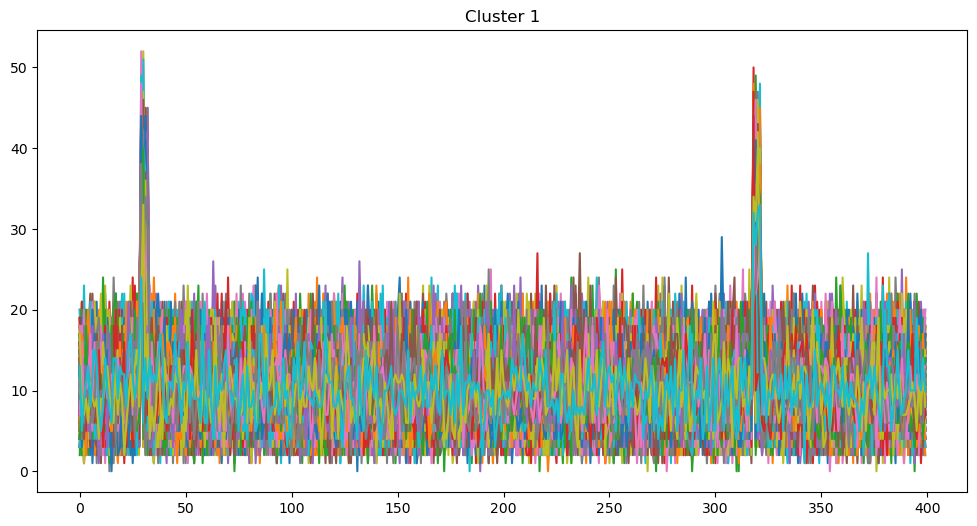

In [14]:
plt.figure(figsize=[12,6])
for i in range(1000):
    X.loc[i,].plot(kind='line')
plt.title('Cluster 1')
plt.show()

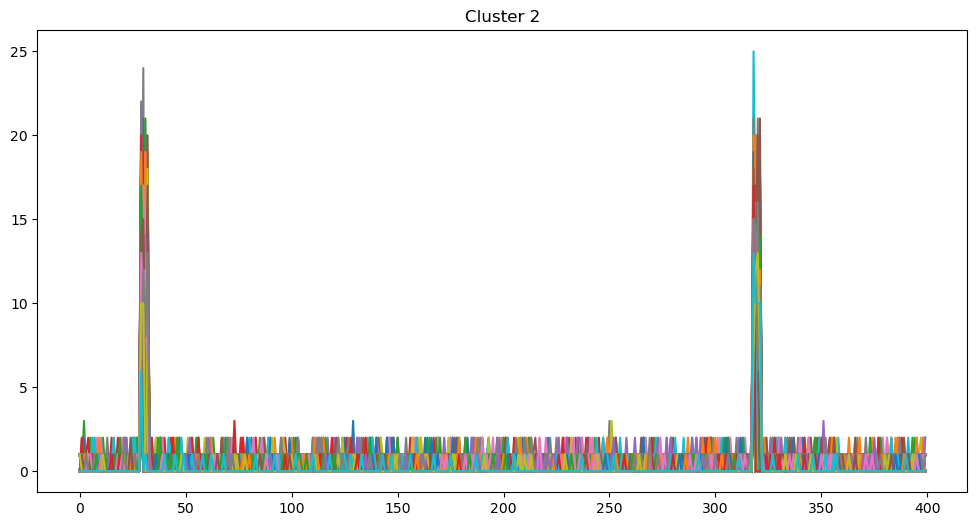

In [15]:
plt.figure(figsize=[12,6])
for i in range(1000,2000):
    X.loc[i,].plot(kind='line')
plt.title('Cluster 2')
plt.show()

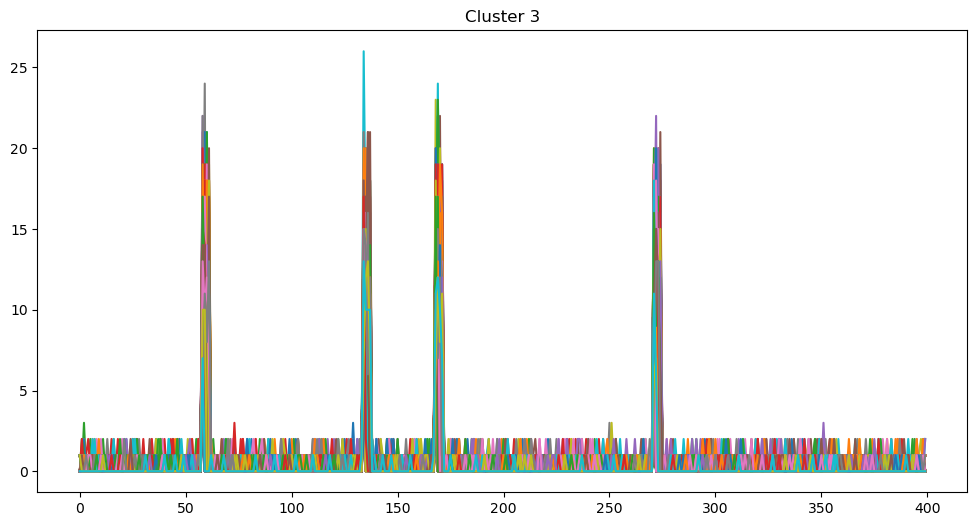

In [16]:
plt.figure(figsize=[12,6])
for i in range(2000,3000):
    X.loc[i,].plot(kind='line')
plt.title('Cluster 3')
plt.show()

## Baseline 1 - Kshape

In [ ]:
import tslearn
from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [34]:
seed = 3
np.random.seed(3)
X_train = X.values
y_train = y.values
# np.random.shuffle(X_train)
# For this method to operate properly, prior scaling is required
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
sz = X_train.shape[1]

# kShape clustering
ks = KShape(n_clusters=3, verbose=True, random_state=seed)
y_pred = ks.fit_predict(X_train)


0.154 --> 0.146 --> 0.141 --> 0.137 --> 0.127 --> 0.105 --> 0.103 --> 0.102 --> 0.102 --> 0.102 --> 0.102 --> 0.102 --> 0.102 --> 


In [50]:
print(f'gt cluster 0: # pred as cluster 0 = {sum(y_pred[:1000]==0)}, # pred as cluster 1 = {sum(y_pred[:1000]==1)}, # pred as cluster 2 = {sum(y_pred[:1000]==2)}')
print(f'gt cluster 1: # pred as cluster 0 = {sum(y_pred[1000:2000]==0)}, # pred as cluster 1 = {sum(y_pred[1000:2000]==1)}, # pred as cluster 2 = {sum(y_pred[1000:2000]==2)}')
print(f'gt cluster 2: # pred as cluster 0 = {sum(y_pred[2000:3000]==0)}, # pred as cluster 1 = {sum(y_pred[2000:3000]==1)}, # pred as cluster 2 = {sum(y_pred[2000:3000]==2)}')

gt cluster 0: # pred as cluster 0 = 0, # pred as cluster 1 = 511, # pred as cluster 2 = 489
gt cluster 1: # pred as cluster 0 = 0, # pred as cluster 1 = 511, # pred as cluster 2 = 489
gt cluster 2: # pred as cluster 0 = 999, # pred as cluster 1 = 1, # pred as cluster 2 = 0


**Kshape can tell between different number of peaks, but doesn't tell between scale**

## Baseline 2 - Kmean

In [51]:
from tslearn.clustering import TimeSeriesKMeans

km = TimeSeriesKMeans(n_clusters=3, metric="dtw",
                         max_iter=10, random_state=seed)
y_pred = km.fit_predict(X_train)


In [52]:
print(f'gt cluster 0: # pred as cluster 0 = {sum(y_pred[:1000]==0)}, # pred as cluster 1 = {sum(y_pred[:1000]==1)}, # pred as cluster 2 = {sum(y_pred[:1000]==2)}')
print(f'gt cluster 1: # pred as cluster 0 = {sum(y_pred[1000:2000]==0)}, # pred as cluster 1 = {sum(y_pred[1000:2000]==1)}, # pred as cluster 2 = {sum(y_pred[1000:2000]==2)}')
print(f'gt cluster 2: # pred as cluster 0 = {sum(y_pred[2000:3000]==0)}, # pred as cluster 1 = {sum(y_pred[2000:3000]==1)}, # pred as cluster 2 = {sum(y_pred[2000:3000]==2)}')

gt cluster 0: # pred as cluster 0 = 0, # pred as cluster 1 = 1000, # pred as cluster 2 = 0
gt cluster 1: # pred as cluster 0 = 0, # pred as cluster 1 = 0, # pred as cluster 2 = 1000
gt cluster 2: # pred as cluster 0 = 976, # pred as cluster 1 = 0, # pred as cluster 2 = 24


## Baseline 3 - Kernel Kmeans

In [53]:
from tslearn.clustering import KernelKMeans

gak_km = KernelKMeans(n_clusters=3,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      verbose=True,
                      random_state=seed)
y_pred = gak_km.fit_predict(X_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
print(f'gt cluster 0: # pred as cluster 0 = {sum(y_pred[:1000]==0)}, # pred as cluster 1 = {sum(y_pred[:1000]==1)}, # pred as cluster 2 = {sum(y_pred[:1000]==2)}')
print(f'gt cluster 1: # pred as cluster 0 = {sum(y_pred[1000:2000]==0)}, # pred as cluster 1 = {sum(y_pred[1000:2000]==1)}, # pred as cluster 2 = {sum(y_pred[1000:2000]==2)}')
print(f'gt cluster 2: # pred as cluster 0 = {sum(y_pred[2000:3000]==0)}, # pred as cluster 1 = {sum(y_pred[2000:3000]==1)}, # pred as cluster 2 = {sum(y_pred[2000:3000]==2)}')

## multivariate synthetic data

In [23]:
import pandas as pd
import numpy as np
import random


def gen_multivar_synthetic_ts(
        length,
        n_dim,
        baseline_poisson_lam=0.05,
        n_peaks=3,
        peak_start_idx=[],
        peak_poisson_lam = None,
        seed=1
):
    """
    generate multivariate synthetic ts
    output: np array of length * n_dim
    """
    # set peak poisson lam
    if peak_poisson_lam is None: peak_poisson_lam = baseline_poisson_lam * 20
    # generate each dimension separately
    ts = np.empty((length,0),dtype=int)
    for d in range(n_dim):
        d_seed = seed + d
        random.seed(d_seed)
        np.random.seed(d_seed)
        ts_tmp = gen_synthetic_ts(
                length,
                baseline_poisson_lam=random.choice(np.arange(baseline_poisson_lam/2,baseline_poisson_lam*2,0.05)),
                n_peaks=random.choice(np.arange(n_peaks-2,n_peaks+3,1)),
                peak_start_idx=peak_start_idx,
                peak_poisson_lam = random.choice(np.arange(peak_poisson_lam/2,peak_poisson_lam*2,0.05)),
                seed=d_seed
        ).reshape((-1,1))
        ts = np.hstack((ts,ts_tmp))

    return ts

def gen_synthetic_ts(
        length,
        baseline_poisson_lam=0.05,
        n_peaks=3,
        peak_start_idx=[],
        peak_poisson_lam = None,
        seed=1
):
    random.seed(seed)
    np.random.seed(seed)
    # set peak poisson lam
    if peak_poisson_lam is None: peak_poisson_lam = baseline_poisson_lam * 20
    # init ts of given length to with a poisson distribution
    ts = np.random.poisson(lam=baseline_poisson_lam,size=length)
    # randomly place n_peaks along the timeline if start indices of peaks not given
    if len(peak_start_idx) != n_peaks:
        peak_start_idx = random.sample(range(length-4),n_peaks) # idx
    # each peak randomly lasts for 1-4 days 
    for i in range(n_peaks):
        peak_length = random.randint(1,4)
        ts_peak = np.random.poisson(lam=peak_poisson_lam,size=peak_length)
        ts[peak_start_idx[i]:peak_start_idx[i]+peak_length] = ts[peak_start_idx[i]:peak_start_idx[i]+peak_length] + ts_peak
    
    return ts

In [24]:
a = gen_multivar_synthetic_ts(
        100,
        2,
        baseline_poisson_lam=0.05,
        n_peaks=3,
        peak_start_idx=[],
        peak_poisson_lam = None,
        seed=1
)

(100, 1)
(100, 1)


In [37]:
#np.stack((a.reshape((a.shape[0],a.shape[1],1)),a.reshape((a.shape[0],a.shape[1],1))))
np.stack((a,a),axis=0).shape


(2, 100, 2)

In [14]:
import pickle

X = pickle.load(open('/nas/home/siyiguo/ts_clustering/data/synthetic_data_X.pkl','rb'))
Y = pickle.load(open('/nas/home/siyiguo/ts_clustering/data/synthetic_data_y.pkl','rb'))

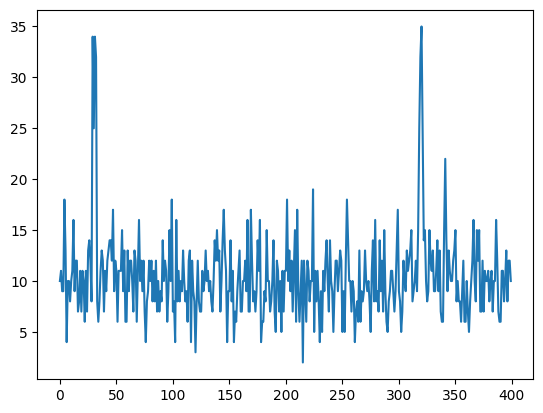

In [15]:
plt.plot(X[0,:,0])

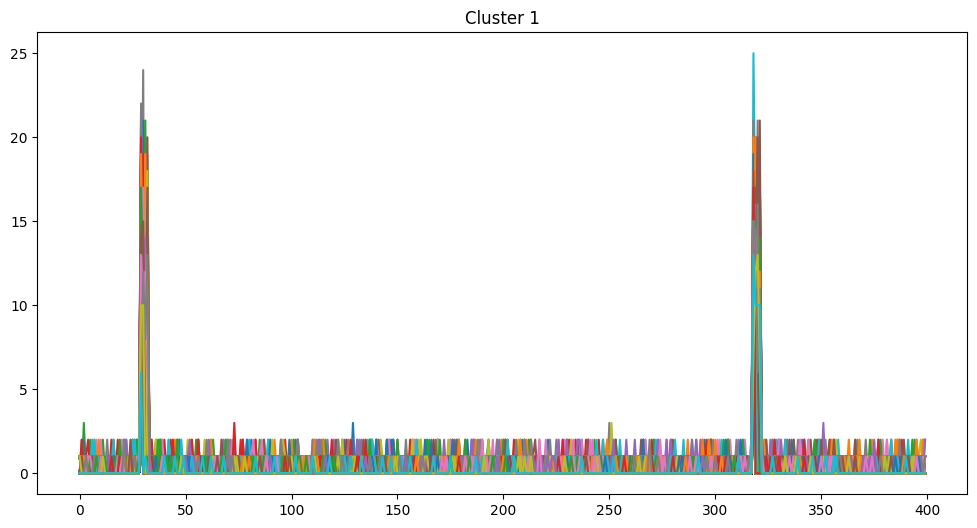

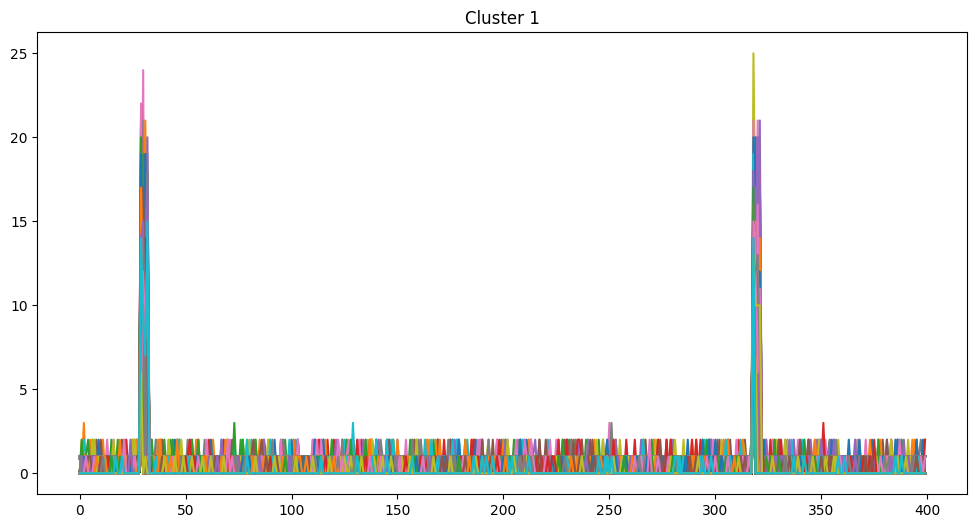

In [21]:
for d in range(2):
    plt.figure(figsize=[12,6]) 
    for i in range(1000,2000):
        plt.plot(X[i,:,d])
    plt.title('Cluster 1')
    plt.show()